In [1]:
!nvidia-smi

Tue Dec 16 15:33:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Import And Split**

In [2]:
# ============================================================
# 0. Setup
# ============================================================
!pip install -q ultralytics

from ultralytics import YOLO
from pathlib import Path
import yaml, shutil, random, xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Dataset paths
BASE  = Path("/kaggle/input/bangladesh-traffic/Bangladeshi Traffic Flow Dataset/Annotated Images")
WORK  = Path("/kaggle/working/traffic_baseline")
SPLIT = WORK / "yolo_split"
DATA  = WORK / "data_traffic.yaml"
WORK.mkdir(parents=True, exist_ok=True)

# Custom folder for all outputs
OUTPUT_FOLDER = Path("/kaggle/working/base_yolov10")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

# ============================================================
# 1. VOC → YOLO conversion + train/val/test split
# ============================================================
def voc2yolo(xml_file, classes, out_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find("size")
    w, h = int(size.find("width").text), int(size.find("height").text)

    with open(out_file, "w") as f:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)

            xmlbox = obj.find("bndbox")
            xmin, ymin = float(xmlbox.find("xmin").text), float(xmlbox.find("ymin").text)
            xmax, ymax = float(xmlbox.find("xmax").text), float(xmlbox.find("ymax").text)

            x = (xmin + xmax) / 2.0 / w
            y = (ymin + ymax) / 2.0 / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h
            f.write(f"{cls_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

def create_split(all_files, ratios=(0.7,0.2,0.1)):
    n = len(all_files)
    n_train = int(ratios[0]*n)
    n_val   = int(ratios[1]*n)
    random.shuffle(all_files)
    return (all_files[:n_train],
            all_files[n_train:n_train+n_val],
            all_files[n_train+n_val:])

def convert_and_split(base_dir, classes, ratios=(0.7,0.2,0.1)):
    if SPLIT.exists():
        shutil.rmtree(SPLIT)

    all_pairs = []
    for ext in ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]:
        for img_file in Path(base_dir).rglob(ext):
            xml_file = img_file.with_suffix(".xml")
            if xml_file.exists():
                all_pairs.append((img_file, xml_file))

    print(f"Found {len(all_pairs)} annotated images total.")
    train, val, test = create_split(all_pairs, ratios)
    splits = {"train":train, "val":val, "test":test}

    for split_name, files in splits.items():
        out_im, out_lb = SPLIT/split_name/"images", SPLIT/split_name/"labels"
        out_im.mkdir(parents=True, exist_ok=True)
        out_lb.mkdir(parents=True, exist_ok=True)

        for img_file, xml_file in files:
            shutil.copy(img_file, out_im/img_file.name)
            voc2yolo(xml_file, classes, out_lb/f"{img_file.stem}.txt")
        print(f"{split_name}: {len(files)} images")

# Classes in dataset
CLASSES = ["Rickshaw","Bus","Truck","Bike","Mini-truck","People","Car","CNG","Cycle"]

print("➤ Converting Pascal VOC → YOLO with auto split …")
convert_and_split(BASE, CLASSES, ratios=(0.7,0.2,0.1))

# Create data.yaml for YOLOv12
DATA.write_text(yaml.dump({
    "path": str(SPLIT),
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "nc": len(CLASSES),
    "names": CLASSES
}))
print("✓ YOLO split ready:", DATA)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultraly

In [3]:
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import math
import matplotlib.pyplot as plt
import glob
import numpy as np
import random
import seaborn as sns
import pandas as pd 
from collections import Counter
import yaml
from PIL import Image
import shutil

**Train Yolo Baseline**

In [4]:
# Load the YAML file
yaml_path = "/kaggle/working/traffic_baseline/data_traffic.yaml"  # Update this
with open(yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)

# Extract class names
class_names = data_yaml["names"]
num_classes = data_yaml["nc"]

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 9
Class names: ['Rickshaw', 'Bus', 'Truck', 'Bike', 'Mini-truck', 'People', 'Car', 'CNG', 'Cycle']


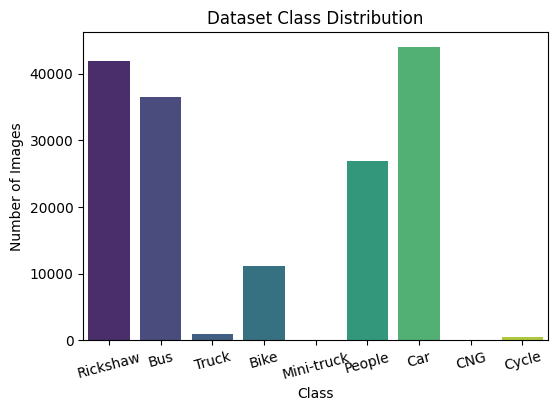

In [5]:
# Define paths
base_path = "/kaggle/working/traffic_baseline/yolo_split/train/labels"  # Update this

# Count occurrences of each class in the dataset
class_counts = {name: 0 for name in class_names}

for label_file in os.listdir(base_path):
    with open(os.path.join(base_path, label_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_idx = int(line.split()[0])  # Get class index
            class_counts[class_names[class_idx]] += 1
class_counts_df = pd.DataFrame(class_counts.items(), columns=["Class", "Count"])

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(data=class_counts_df, x="Class", y="Count", palette="viridis")
plt.title("Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.show()

In [6]:
import os
import collections

# Define paths
label_dir = "/kaggle/working/traffic_baseline/yolo_split/train/labels"

# Count labels per class
class_counts = collections.defaultdict(int)

# Read label files
for label_file in os.listdir(label_dir):
    with open(os.path.join(label_dir, label_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID (assuming first value in YOLO format)
            class_counts[class_id] += 1

# Print class distribution
print("Class Distribution Before Balancing:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count} images")

# Find the target count (max of any class)
target_count = min(class_counts.values())
print(f"\nTarget count for all classes: {target_count}")

Class Distribution Before Balancing:
Class 0: 41947 images
Class 1: 36451 images
Class 2: 923 images
Class 3: 11099 images
Class 5: 26970 images
Class 6: 44002 images
Class 8: 507 images

Target count for all classes: 507


In [7]:
import shutil
import random

# Define paths
train_images_dir = "/kaggle/working/traffic_baseline/yolo_split/train/images"
train_labels_dir = "/kaggle/working/traffic_baseline/yolo_split/train/labels"

# Target count (smallest class count)
target_count = min(class_counts.values())  # 503 in this case

# Get all class 0 files
class_0_files = []
for lbl_file in os.listdir(train_labels_dir):
    with open(os.path.join(train_labels_dir, lbl_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            if int(line.split()[0]) == 0:  # Check if it's Class 0
                class_0_files.append(lbl_file)
                break  # Only need to check the first line

# Randomly select Class 0 files to keep
files_to_keep = set(random.sample(class_0_files, target_count))
files_removed = []

# Remove extra files
for lbl_file in class_0_files:
    if lbl_file not in files_to_keep:
        img_file = lbl_file.replace(".txt", ".jpg")

        src_label = os.path.join(train_labels_dir, lbl_file)
        src_image = os.path.join(train_images_dir, img_file)

        # Move to a backup folder instead of deleting (optional)
        backup_dir = "/kaggle/working/removed_samples"
        os.makedirs(backup_dir, exist_ok=True)
        shutil.move(src_label, os.path.join(backup_dir, lbl_file))
        shutil.move(src_image, os.path.join(backup_dir, img_file))

        files_removed.append(lbl_file)

print("\n✅ **Undersampling Completed!**")
print(f"🗑 Removed {len(files_removed)} files from Class 0")


✅ **Undersampling Completed!**
🗑 Removed 13095 files from Class 0


In [8]:
# Recalculate class distribution after undersampling
from collections import Counter
import os

train_labels_dir = "/kaggle/working/traffic_baseline/yolo_split/train/labels"

final_class_counts = Counter()
for lbl_file in os.listdir(train_labels_dir):
    with open(os.path.join(train_labels_dir, lbl_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID
            final_class_counts[class_id] += 1

print("\n✅ **Final Class Distribution After Undersampling:**")
for class_id, count in final_class_counts.items():
    print(f"Class {class_id}: {count} images")


✅ **Final Class Distribution After Undersampling:**
Class 6: 8621 images
Class 1: 5198 images
Class 2: 303 images
Class 5: 2987 images
Class 0: 1541 images
Class 3: 1736 images
Class 8: 83 images


In [9]:
import yaml

# Path to data.yaml in the working directory
yaml_path = "/kaggle/working/traffic_baseline/data_traffic.yaml"

# Load the existing YAML file
with open(yaml_path, "r") as file:
    data = yaml.safe_load(file)

# Add/Modify augmentation settings (YOLOv12 supports these augmentations)
data["augment"] = {
    "mosaic": True,
    "mixup": 0.2,
    "hsv_h": 0.015,
    "hsv_s": 0.7,
    "hsv_v": 0.4,
    "perspective": 0.0005,
    "shear": 0.0001,
    "flipud": 0.5,
    "fliplr": 0.5,
    "rotate": 5.0,
    "scale": 0.5
}

# Save the updated YAML file
with open(yaml_path, "w") as file:
    yaml.dump(data, file, default_flow_style=False)

print("✅ `data.yaml` updated successfully with on-the-fly augmentations!")

✅ `data.yaml` updated successfully with on-the-fly augmentations!


✅ Image loaded successfully!


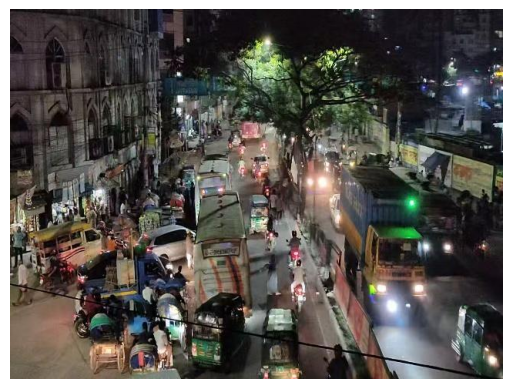

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = "/kaggle/working/traffic_baseline/yolo_split/train/images/frame0_jpg.rf.3f5960d95ab5f95d9596d6b281f77308.jpg"
label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
# Ensure the image exists before processing
if os.path.exists(img_path):
    img = cv2.imread(img_path)
    
    if img is not None:  # Check if image is successfully read
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print("✅ Image loaded successfully!")
    else:
        print("⚠️ Error: Image could not be loaded. Possible corruption:", img_path)
else:
    print("❌ Image path does not exist:", img_path)
# Example: Load an image and overlay its polygon annotation


# Read image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Read annotations
with open(label_path, "r") as f:
    lines = f.readlines()

for line in lines:
    values = list(map(float, line.split()))
    class_id = int(values[0])
    polygon = values[1:]  # Polygon coordinates

    # Convert YOLO polygon format to image points
    points = [(int(polygon[i] * img.shape[1]), int(polygon[i+1] * img.shape[0])) for i in range(0, len(polygon), 2)]
    
    # Draw polygon
    cv2.polylines(img, [np.array(points)], isClosed=True, color=(255, 0, 0), thickness=2)

# Show image with annotations
plt.imshow(img)
plt.axis("off")
plt.show()

In [11]:
import yaml

# Define the correct paths for your dataset
data_yaml_path = "/kaggle/working/traffic_baseline/data_traffic.yaml"  # Save in working directory

correct_paths = {
    "train": "/kaggle/working/traffic_baseline/yolo_split/train/images",  # Update this path
    "val": "/kaggle/working/traffic_baseline/yolo_split/val/images",  # Update this path
    "test": "/kaggle/working/traffic_baseline/yolo_split/test",  # Update this path
    "nc": 9,  # Number of classes
    "names": ['Rickshaw', 'Bus', 'Truck', 'Bike', 'Mini-truck', 'People', 'Car', 'CNG', 'Cycle']  # Class names
}

# Save the updated data.yaml
with open(data_yaml_path, "w") as file:
    yaml.dump(correct_paths, file, default_flow_style=False)

print(f"✅ Updated data.yaml saved at: {data_yaml_path}")

✅ Updated data.yaml saved at: /kaggle/working/traffic_baseline/data_traffic.yaml


In [12]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [13]:
from ultralytics import YOLO
model = YOLO("yolov10s.pt")

In [14]:
import time

# Start time
start_time = time.time()

# Train the model
results = model.train(
   data='/kaggle/working/traffic_baseline/data_traffic.yaml',
   imgsz=640,
   epochs=50,
   batch=16,
    device='0,1',
   name='yolov10s.pt',
)

# End time
end_time = time.time()

# Calculate total time taken
total_time = end_time - start_time
minutes = int(total_time // 60)
seconds = int(total_time % 60)

# Display training summary
print(f"✅ Training Completed!")
print(f"🕒 Time Taken: {minutes} min {seconds} sec")
print(f"🔄 Total Epochs: {results.epochs}")

Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/traffic_baseline/data_traffic.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov10s.pt, nbs=64, nms=False, o

/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:74: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at /pytorch/aten/src/ATen/native/cuda/jit_utils.cpp:1442.)
  inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 148/148 6.9it/s 21.4s
                   all       4735      46772      0.565      0.464      0.439      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.95G      2.833      2.773      2.329         46        640: 100% ━━━━━━━━━━━━ 218/218 4.4it/s 49.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 148/148 7.1it/s 20.9s
                   all       4735      46772       0.59      0.467      0.458      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      3.02G      2.848      2.611       2.36         30        640: 100% ━━━━━━━━━━━━ 218/218 4.4it/s 50.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 148/148 7.1it/s 21.0s
                   all       4735   

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46772      0.609      0.628      0.648      0.414
              Rickshaw       3885      12187      0.774        0.7      0.792      0.505
                   Bus       3903      10357       0.71      0.801       0.82       0.55
                 Truck        241        257      0.329      0.266      0.268      0.194
                  Bike       2106       3188      0.685      0.754      0.777       0.43
                People       2914       7928      0.691       0.77      0.802       0.48
                   Car       4285      12712      0.777      0.872      0.902      0.648
                 Cycle        137        143      0.299      0.231      0.177     0.0936
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /kaggle/working/runs/detect/yolov10s.pt
✅ Training Completed!
🕒 Time Taken: 60 min 47 sec


AttributeError: 'NoneType' object has no attribute 'epochs'

In [ ]:
import shutil

# Define the folder path and output ZIP file
source_folder = "/kaggle/working/runs/detect/yolov10s.pt"  # Folder you want to zip
zip_path = "/kaggle/working/yolov10s.zip"  # Output ZIP file

# Create the ZIP file
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', source_folder)

print(f"✅ ZIP file created: {zip_path}")

In [ ]:
from ultralytics import YOLO

# Load your trained YOLOv10 model
model = YOLO("/kaggle/working/runs/detect/yolov10s.pt/weights/best.pt")

# Run validation on the test/valid dataset
metrics = model.val(data="/kaggle/working/traffic_baseline/data_traffic.yaml")

# Print all metrics
print("\n📊 **Full YOLO Model Evaluation Report:**")
print(metrics)

In [ ]:
import pandas as pd
import seaborn as sns 

df = pd.read_csv('/kaggle/working/runs/detect/yolov10s.pt/results.csv')

metrics = ['train/box_loss','train/cls_loss','train/dfl_loss','val/box_loss','val/cls_loss','val/dfl_loss']

plt.figure(figsize=(10, 6))

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='epoch', y=metric, data=df, label="YOLOv10l")
    
    plt.title(f"{metric} metric's relationship to the Epoch version")
    plt.xlabel("Epochs")
    plt.ylabel(f"{metric}")
    plt.legend(title="Metrics")
    plt.tight_layout()
    
    plt.show()

**Evaluate**

In [ ]:
paths2=[]
for dirname, _, filenames in os.walk('/kaggle/working/runs/detect/val'):
    for filename in filenames:
        if filename[-4:]=='.png' or filename[-4:]=='.jpg':
            paths2+=[(os.path.join(dirname, filename))]
paths2=sorted(paths2)
print(len(paths2))
print(paths2[0:3])

In [ ]:
for path in paths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    plt.show()

In [ ]:
# ============================================================
# 3. Evaluate on test set + generate plots (outputs in same folder)
# ============================================================
metrics = model.val(
    data=str(DATA),
    split="test",
    plots=True,
    project=str(OUTPUT_FOLDER),  # <- same output folder
    name="val"
)

print("mAP@0.5     :", metrics.box.map50)
print("mAP@[.5:.95]:", metrics.box.map)
print("Precision   :", metrics.box.mp)
print("Recall      :", metrics.box.mr)

In [ ]:
# ============================================================
# 4. Visualize PR curve from custom folder
# ============================================================
pr_curve_file = list((OUTPUT_FOLDER/"val").glob("*PR_curve*.png"))[0]
img = mpimg.imread(pr_curve_file)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (replace with your actual file path)
# For example, if you uploaded 'data.csv' to Kaggle:
df = pd.read_csv("/kaggle/working/runs/detect/yolov10s.pt/results.csv")

# Show basic info
print(df.head())

# Compute correlation matrix
corr = df.corr()

# Set figure size
plt.figure(figsize=(12,8))

# Create heatmap
sns.heatmap(corr,
annot=True, # Show correlation values
cmap='coolwarm', # Color palette
fmt=".2f", # Decimal format
linewidths=0.5, # Lines between cells
square=True)

# Add title
plt.title("Feature Correlation Heatmap", fontsize=16)

# Show the plot
plt.show()